# Figure. CNV eQTL Examples

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtl_examples'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'cnv_gene_variants.pickle')
cnv_gv = pd.read_pickle(fn)

fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'lead_variants.pickle')
lead_vars = pd.read_pickle(fn)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'reg_results.tsv')
mcnv_results = pd.read_table(fn, index_col=0)
mcnv_sig = mcnv_results[mcnv_results.bh_sig]

fn = os.path.join(ciepy.root, 'private_output', 'mcnv_analysis', 'filtered_mcnvs.tsv')
mcnv_genotypes = pd.read_table(fn, index_col=0)

In [4]:
cnv_lead_vars = cnv_gv[cnv_gv.cnv_is_lead]
cnv_lead_vars = cnv_lead_vars.sort_values(by='pvalue').drop_duplicates(subset=['gene_id'])

In [5]:
mcnv_genotypes.shape

(162, 131)

In [6]:
mcnv_sig.cnv.value_counts().head(12)

CNV_17_44566797_44580424     11
CNV_17_44336433_44367851     10
CNV_17_44311202_44328032     10
CNV_17_43650217_43655844      7
CNV_1_16885240_16950375       7
CNV_7_143951166_143953316     7
CNV_17_43655545_43662029      6
CNV_10_46945989_47151257      6
CNV_8_11979660_12009126       6
CNV_8_12427702_12432588       5
CNV_1_16951816_16969312       5
CNV_8_12395839_12427801       5
Name: cnv, dtype: int64

In [7]:
n = 143953316 - 143951166
print('mCNV length is {:,}.'.format(n))

mCNV length is 2,150.


In [8]:
c = 'CNV_7_143951166_143953316'
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'CNV_7_143951166_143953316_data.tsv')
data = pd.read_table(fn, index_col=0)
data.columns = list(data.columns[0:-1]) + ['Gene']

In [9]:
sns.set_style('whitegrid')

In [10]:
mcnv_sig[mcnv_sig.cnv == 'CNV_7_143951166_143953316'].gene_name

1340      AC004889.1
1701       OR2A1-AS1
1808       ARHGEF34P
2063           OR2A7
2352         ARHGEF5
2449         CTAGE15
2879    RP4-545C24.1
Name: gene_name, dtype: object

In [11]:
legend_colors = [
    np.array((255,0,0)) / 255.,
    np.array((255,105,105)) / 255.,
    np.array((250,202,0)) / 255.,
    np.array((255,252,4)) / 255.,
    np.array((10,190,254)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((153,255,102)) / 255.,
    np.array((245,245,245)) / 255.,
    ]
ind = [
    'Active promoter',
    'Weak promoter',
    'Strong enhancer',
    'Weak/poised enhancer',
    'Insulator',
    'Transcriptional transition',
    'Transcriptional elongation',
    'Weak transcribed',
    'Heterochromatin',
]
legend_colors = pd.Series(legend_colors, index=ind)

In [12]:
s,p = stats.mannwhitneyu(cnv_lead_vars.drop_duplicates('gene_id').beta.abs(),
                         lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs())
print('Effect sizes are different with p={:.3e}, Mann Whitney U.'.format(p))

Effect sizes are different with p=7.017e-10, Mann Whitney U.


In [13]:
cnv_abs_beta_pdf = pd.Series(index=np.arange(0, 3 + 0.1, 0.1))
se = cnv_lead_vars.drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
cnv_abs_beta_pdf = pd.Series(density(cnv_abs_beta_pdf.index), index=cnv_abs_beta_pdf.index)
snv_abs_beta_pdf = pd.DataFrame(index=np.arange(0, 3 + 0.005, 0.005))
se = lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
snv_abs_beta_pdf = pd.Series(density(snv_abs_beta_pdf.index), index=snv_abs_beta_pdf.index)

In [14]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'sig_not_genic_vs_not_sig_roadmap_res.tsv')
intergenic_res = pd.read_table(fn, index_col=0)

repressive = ['H3K9me3', 'H3K27me3']
transcribed = ['H3K36me3']
intergenic_res['type'] = 'Active'
for i in repressive:
    intergenic_res.ix[intergenic_res.mark == i, 'type'] = 'Repressive'
for i in transcribed:
    intergenic_res.ix[intergenic_res.mark == i, 'type'] = 'Transcribed'

intergenic_res['mark_mean'] = np.nan
for m in set(intergenic_res.mark):
    ind = intergenic_res[intergenic_res.mark == m].index
    intergenic_res.ix[ind, 'mark_mean'] = intergenic_res.ix[ind, 'neg_log_pvalue'].mean()

intergenic_res.sort_values(by=['type', 'mark_mean'], inplace=True, ascending=[True, False])

In [15]:
data['CNV_7_143951166_143953316'] = data.CNV_7_143951166_143953316.astype(int)

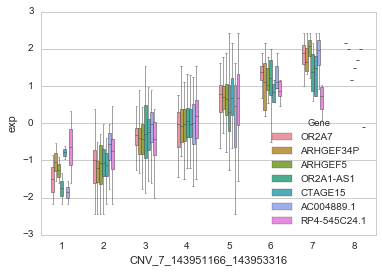

In [16]:
sns.boxplot(x='CNV_7_143951166_143953316', y='exp', hue='Gene', data=data, width=0.5,
           fliersize=0, linewidth=0.5);

For the purposes of plotting I'll group 7 and 8 and call it 7+. I have a feeling the
8 calls are really seven. I also think the one calls are really 2 but I'll leave it.

In [17]:
data_f = data.copy(deep=True)
data_f.ix[data.CNV_7_143951166_143953316 == 8, 'CNV_7_143951166_143953316'] = 7

49 lead intergenic CNV eGenes.
Effect sizes for intergenic lead CNVs are biased (p=9.264e-06, binomial test).


/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


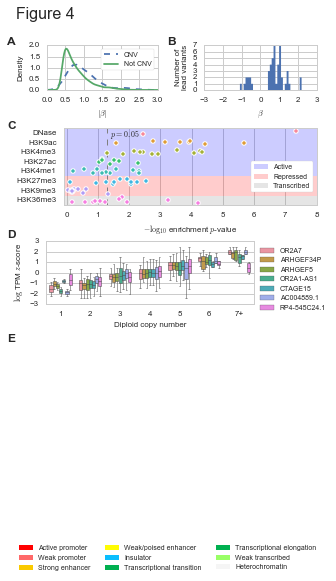

In [18]:
fig = plt.figure(figsize=(4.5, 8), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 4',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.92, 1, 1])

# SNV/indel lead vs. CNV lead effect size
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax, linestyle='--')
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\left|\\beta\\right|$', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.legend(fontsize=7, frameon=True, fancybox=True)
gs.tight_layout(fig, rect=[0, 0.77, 0.52, 0.94])

# Lead variant CNV not overlapping gene
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
g = cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene_cons, 'gene_id']
t = cnv_lead_vars[cnv_lead_vars.gene_id.apply(lambda x: x not in g.values)]
bins = np.arange(-3, 3.1, 0.1)
t.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
p = stats.binom_test((t.drop_duplicates('gene_id').beta > 0).value_counts())
print('{:,} lead intergenic CNV eGenes.'.format(t.drop_duplicates('gene_id').shape[0]))
print('Effect sizes for intergenic lead CNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of\nlead variants', fontsize=8)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0.48, 0.77, 1, 0.94])

# Functional annotation enrichment
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
sns.stripplot(x='neg_log_pvalue', y='mark', data=intergenic_res, jitter=0.3, 
              ax=ax, orient='h', size=4.5)
for t in ax.get_xticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$-\\log_{10}$ enrichment $p$-value', fontsize=8)
xmin,xmax = ax.get_xlim()
ax.set_xlim(-0.1, xmax)
ymin,ymax = ax.get_ylim()
ax.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', color='grey',
          linewidth=1)
ax.text(-np.log10(0.05) + 0.1, ymax, '$p=0.05$', ha='left', va='top', fontsize=8)
ax.axhspan(-0.5, 4.5, facecolor='blue', alpha=0.2, label='Active', lw=0)
ax.axhspan(4.5, 6.5, facecolor='red', alpha=0.2, label='Repressed', lw=0)
ax.axhspan(6.5, 7.5, facecolor='grey', alpha=0.2, label='Transcribed', lw=0)
ax.legend(frameon=True, fancybox=True, loc=[0.74, 0.17], fontsize=7)
ax.set_ylabel('')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.57, 1, 0.79])

# mCNV eQTL gene expression
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
sns.boxplot(x='CNV_7_143951166_143953316', y='exp', hue='Gene', data=data_f, 
            width=0.75, fliersize=0, linewidth=0.5)
ax.set_xticklabels([str(x) for x in range(1,7)] + ['7+'])
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_ylabel('$\log$ TPM $z$-score', fontsize=8)
ax.set_xlabel('Diploid copy number', fontsize=8)
ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1, 1))
gs.tight_layout(fig, rect=[0, 0.4, 0.8, 0.6])

# mCNV legend
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ciepy.clean_axis(ax)
rects = []
labels = []
for k in legend_colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=legend_colors[k]))
lgd = ax.legend(rects, labels, loc='center', prop={'size':7}, ncol=3)
for p in lgd.get_patches():
    p.set_linewidth(0)
gs.tight_layout(fig, rect=[0, 0, 1, 0.05])

t = fig.text(0.005, 0.915, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.915, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.77, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.58, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.4, 'E', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'cnv_examples_skeleton.pdf'))

In [19]:
%%R

suppressPackageStartupMessages(library(Gviz))
suppressPackageStartupMessages(library(GenomicFeatures))

In [20]:
chrom = 'chr7'
start = 143851293
end = 144061217
fontsize = 6
cnv_color = '#000000'
cepbp_color = "#20B2AA"
dnase_color = "#663399"
cnvs = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_cnvs.bed')

In [21]:
%%R -i data,chrom,start,end,fontsize,cepbp_color,dnase_color,cnv_color,cnvs

cnvTrack <- AnnotationTrack(
    range=cnvs, 
    genome="hg19",
    chromosome=chrom, 
    start=start, 
    end=end,
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="CNVs",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
    )

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=8, 
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="chromHMM",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

cebpbTrack <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsSydhH1hescCebpbIggrabUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="CEBPB",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=fontsize,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

cnvTrack = setPar(cnvTrack, "fill", cnv_color)
cebpbTrack = setPar(cebpbTrack, "fill", cepbp_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Note that the behaviour of the 'setPar' method has changed. You need to reassign the result to an object for the side effects to happen. Pass-by-reference semantic is no longer supported.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [22]:
fn = os.path.join(outdir, 'CNV_7_143951166_143953316_region.pdf')

In [23]:
%%R -i fn,chrom,start,end

pdf(fn, 4.5, 3)
plotTracks(c(gtrack, biomTrack, cnvTrack, cebpbTrack, dnaseTrack, hmmTrack), chromosome=chrom, 
           from=start, to=end, col.title="black", sizes=c(0.22, 1, 0.12, 0.12, 0.12, 0.12))
dev.off()

png 
  2 


In [24]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [25]:
gene_info[gene_info.gene_name == 'CTAGE15']

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000176227.9,CTAGE15,pseudogene,chr7,143268818,143271478,+,KNOWN,ENSEMBL,3
ENSG00000271079.1,CTAGE15,protein_coding,chr7,143268893,143271480,+,KNOWN,HAVANA,2


## Presentation

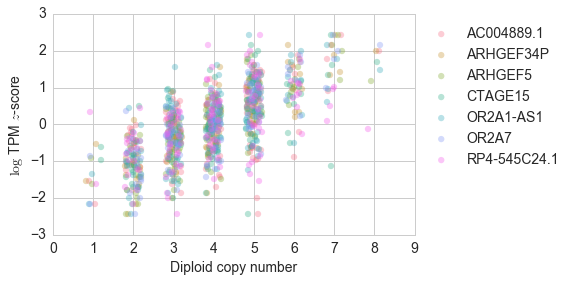

In [26]:
fig,ax = plt.subplots(1, 1)

fs = 14

for i,g in enumerate(sorted(list(set(data.Gene)))):
    t = data[data.Gene == g]
    sns.regplot(x='CNV_7_143951166_143953316', y='exp', data=t,
                x_jitter=0.2, fit_reg=False, ax=ax, label=g,
                color=sns.color_palette('husl', 7)[i], scatter_kws={'alpha':0.35, 's':40})
lgd = ax.legend(fontsize=fs, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('$\log$ TPM $z$-score', fontsize=fs)
ax.set_xlabel('Diploid copy number', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
    
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'CNV_7_143951166_143953316_reg.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')